<a href="https://colab.research.google.com/github/ssungg/AI-and-Information-Security/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/인공지능과 정보보호/1206/UNSW-NB15_training_testing.csv')

In [ ]:
data.shape

(257672, 45)

##전처리

초기 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257672 entries, 0 to 257671
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257672 non-null  int64  
 1   dur                257672 non-null  float64
 2   proto              257672 non-null  object 
 3   service            257672 non-null  object 
 4   state              257672 non-null  object 
 5   spkts              257672 non-null  int64  
 6   dpkts              257672 non-null  int64  
 7   sbytes             257672 non-null  int64  
 8   dbytes             257672 non-null  int64  
 9   rate               257672 non-null  float64
 10  sttl               257672 non-null  int64  
 11  dttl               257672 non-null  int64  
 12  sload              257672 non-null  float64
 13  dload              257672 non-null  float64
 14  sloss              257672 non-null  int64  
 15  dloss              257672 non-null  int6

<ipython-input-3-80d3c13b2c5f>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['service'].replace('-', np.nan, inplace=True)


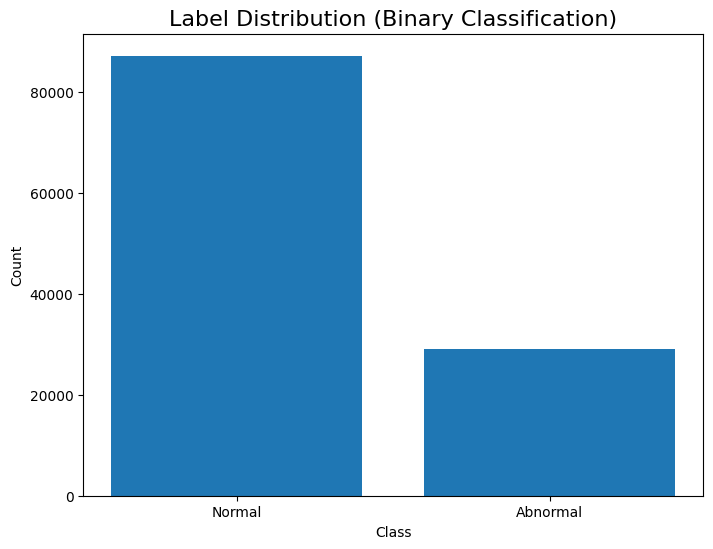

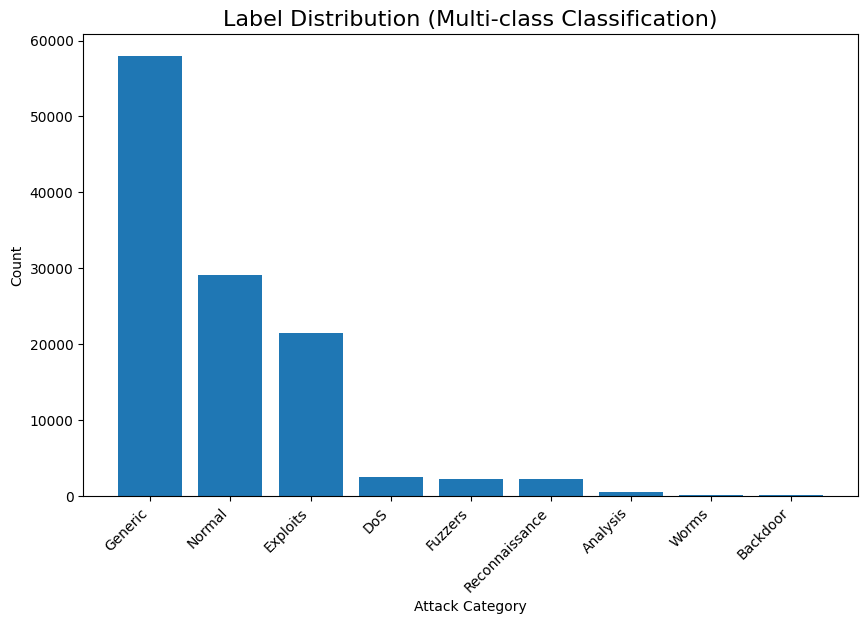

이중분류 - 훈련 데이터 크기: (93081, 56)
다중분류 - 훈련 데이터 크기: (93081, 56)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. 데이터셋 로드
data = pd.read_csv('/content/drive/MyDrive/인공지능과 정보보호/1206/UNSW-NB15_training_testing.csv')

# 2. 데이터셋 초기 확인
print("초기 데이터 정보:")
data.info()
print("초기 데이터 크기:", data.shape)

# 3. 불필요한 컬럼 제거
data.drop(['id'], axis=1, inplace=True)

# 4. 결측값 처리
data['service'].replace('-', np.nan, inplace=True)
data.dropna(inplace=True)

# 5. UNSW-NB15_features.csv 파일 로드 및 타입별 데이터 컬럼 분류
import chardet
with open('/content/drive/MyDrive/인공지능과 정보보호/NUSW-NB15_features.csv', 'rb') as file:
    result = chardet.detect(file.read())

features = pd.read_csv('/content/drive/MyDrive/인공지능과 정보보호/NUSW-NB15_features.csv', encoding=result['encoding'])
features['Type '] = features['Type '].str.lower()

# 데이터 타입별 컬럼 분류
nominal_names = features['Name'][features['Type '] == 'nominal']
integer_names = features['Name'][features['Type '] == 'integer']
binary_names = features['Name'][features['Type '] == 'binary']
float_names = features['Name'][features['Type '] == 'float']

# 데이터셋의 유효한 컬럼만 선택
cols = data.columns
nominal_names = cols.intersection(nominal_names)
integer_names = cols.intersection(integer_names)
binary_names = cols.intersection(binary_names)
float_names = cols.intersection(float_names)

# 데이터 타입 변환
for c in integer_names.union(binary_names).union(float_names):
    data[c] = pd.to_numeric(data[c])

# 6. 데이터 시각화 (라벨 분포)
plt.figure(figsize=(8, 6))
binary_counts = data['label'].value_counts()
binary_labels = ['Normal', 'Abnormal']
plt.bar(binary_labels, binary_counts)
plt.title("Label Distribution (Binary Classification)", fontsize=16)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=range(len(binary_labels)), labels=binary_labels)
plt.show()

plt.figure(figsize=(10, 6))
multi_counts = data['attack_cat'].value_counts()
plt.bar(multi_counts.index, multi_counts.values,)
plt.title("Label Distribution (Multi-class Classification)", fontsize=16)
plt.xlabel("Attack Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

# 7. 원-핫 인코딩 (범주형 데이터)
cat_col = data.select_dtypes(include='object').columns.difference(['attack_cat'])
data = pd.get_dummies(data, columns=cat_col, drop_first=True)

# 8. 정규화 (숫자형 데이터)
num_col = data.select_dtypes(include='number').columns.difference(['label', 'attack_cat_encoded'])
scaler = StandardScaler()
data[num_col] = scaler.fit_transform(data[num_col])

# 9. 타겟 인코딩
# 다중분류 타겟 (attack_cat)
label_encoder = LabelEncoder()
data['attack_cat_encoded'] = label_encoder.fit_transform(data['attack_cat'])

# 이진분류 타겟 (label: 정상, 비정상)
y_binary = data['label']

# 다중분류 타겟 (attack_cat_encoded)
y_multi = data['attack_cat_encoded']

# 입력 데이터에서 타겟 제거
X = data.drop(['label', 'attack_cat', 'attack_cat_encoded'], axis=1)

# 10. 데이터 분할
# 이중분류 데이터 분할
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# 다중분류 데이터 분할
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

# 데이터 크기 확인
print("이중분류 - 훈련 데이터 크기:", X_train_binary.shape)
print("다중분류 - 훈련 데이터 크기:", X_train_multi.shape)


In [ ]:
# 다중분류에서 Normal 클래스 제거
data_multi = data[data['attack_cat'] != 'Normal']

# 다시 다중분류 타겟 인코딩
data_multi['attack_cat_encoded'] = label_encoder.fit_transform(data_multi['attack_cat'])

# 다중분류 타겟 (attack_cat_encoded)
y_multi = data_multi['attack_cat_encoded']

# 입력 데이터에서 타겟 제거
X_multi = data_multi.drop(['label', 'attack_cat', 'attack_cat_encoded'], axis=1)

# 다중분류 데이터 분할
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

# 데이터 크기 및 분포 확인
print("다중분류 (Normal 제거) - 훈련 데이터 크기:", X_train_multi.shape)
print("다중분류 (Normal 제거) - 테스트 데이터 크기:", X_test_multi.shape)
print("\n다중분류 라벨 분포 (훈련 데이터):")
print(y_train_multi.value_counts())
print("\n다중분류 라벨 분포 (테스트 데이터):")
print(y_test_multi.value_counts())


<ipython-input-5-961b2a08da79>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_multi['attack_cat_encoded'] = label_encoder.fit_transform(data_multi['attack_cat'])


다중분류 (Normal 제거) - 훈련 데이터 크기: (69791, 56)
다중분류 (Normal 제거) - 테스트 데이터 크기: (17448, 56)

다중분류 라벨 분포 (훈련 데이터):
attack_cat_encoded
5    46365
3    17184
2     2006
4     1813
6     1766
0      451
7      118
1       88
Name: count, dtype: int64

다중분류 라벨 분포 (테스트 데이터):
attack_cat_encoded
5    11591
3     4296
2      502
4      453
6      441
0      113
7       30
1       22
Name: count, dtype: int64


In [ ]:
# LabelEncoder로 인코딩된 클래스 이름 확인
class_mapping = dict(enumerate(label_encoder.classes_))
print("Encoded Class Mapping:")
for encoded_label, class_name in class_mapping.items():
    print(f"{encoded_label}: {class_name}")

Encoded Class Mapping:
0: Analysis
1: Backdoor
2: DoS
3: Exploits
4: Fuzzers
5: Generic
6: Reconnaissance
7: Worms


In [ ]:
# 성능 기록을 위한 데이터프레임 생성
performance_data = []

##결정트리

###1.기본

Performance Metrics:
Accuracy: 0.9796
Recall: 0.9871
Precision: 0.9857
F1-Score: 0.9864
Time to Train: 5.4121 seconds
Time to Predict: 0.0413 seconds

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



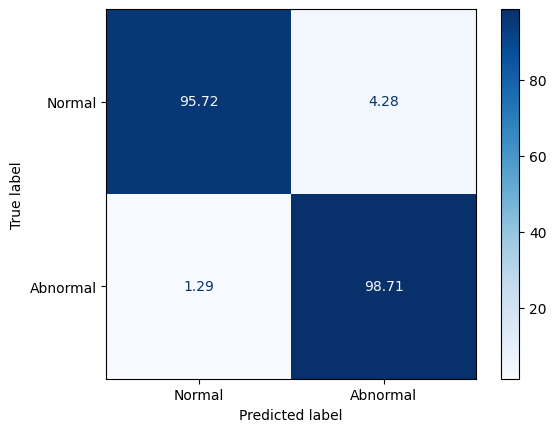

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 1. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 4. 성능 기록
performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


Performance Metrics (Decision Tree - Multi-class):
Accuracy: 0.9282
Recall: 0.9282
Precision: 0.9310
F1-Score: 0.9295
Time to Train: 1.3647 seconds
Time to Predict: 0.0069 seconds

Classification Report (Decision Tree - Multi-class):
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       113
           1       0.29      0.36      0.32        22
           2       0.40      0.45      0.43       502
           3       0.88      0.85      0.87      4296
           4       0.92      0.92      0.92       453
           5       0.99      0.99      0.99     11591
           6       0.49      0.54      0.51       441
           7       0.54      0.47      0.50        30

    accuracy                           0.93     17448
   macro avg       0.66      0.67      0.66     17448
weighted avg       0.93      0.93      0.93     17448



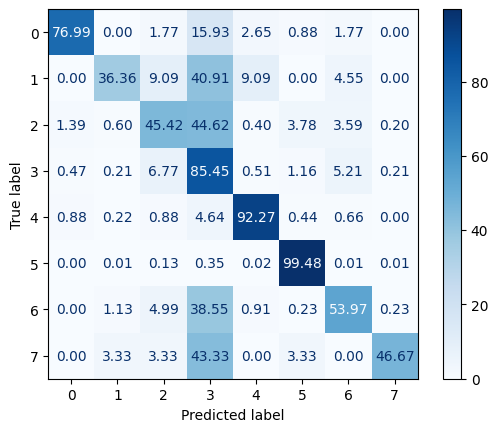

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 성능 기록용 리스트
performance_data = []

# 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 1. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 4. 성능 기록
performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics (Decision Tree - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report (Decision Tree - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###2. 특성 추출

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Selection - Binary Classification):
Accuracy: 0.9792
Recall: 0.9871
Precision: 0.9852
F1-Score: 0.9862
Time to Train: 0.9888 seconds
Time to Predict: 0.0035 seconds

Classification Report (Decision Tree with Feature Selection - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



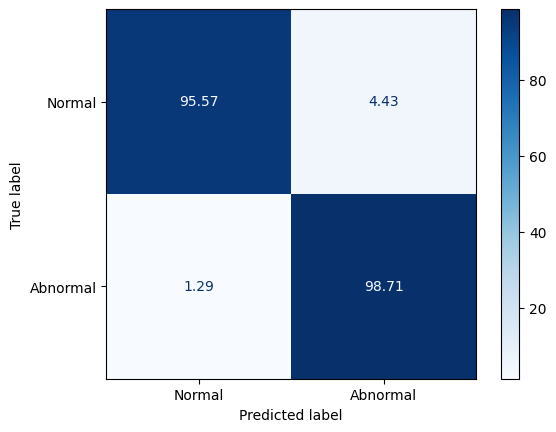

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 선택 (결정트리 특성 중요도 기반)
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_binary, y_train_binary)  # 전체 데이터로 훈련
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_binary_reduced = selector.transform(X_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_reduced, y_train_binary)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

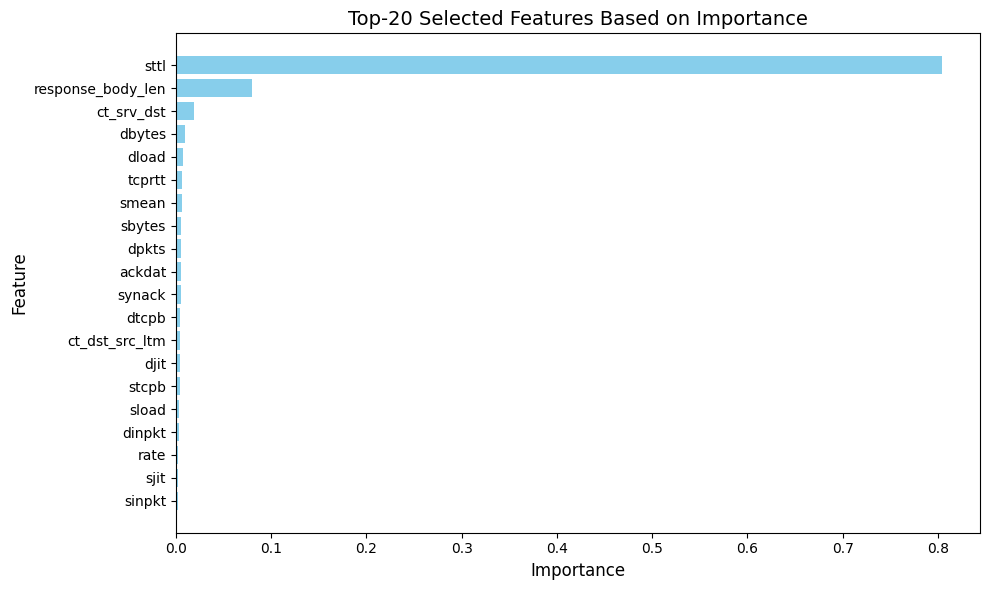

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 선택된 특징의 인덱스와 이름
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_binary.columns[selected_feature_indices]

# 선택된 특징의 중요도 추출
selected_feature_importances = importances[selected_feature_indices]

# 데이터프레임 생성 (이름과 중요도)
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': selected_feature_importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.title('Top-20 Selected Features Based on Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Selection - Multi-class):
Accuracy: 0.9316
Recall: 0.9316
Precision: 0.9331
F1-Score: 0.9322
Time to Train: 0.9421 seconds
Time to Predict: 0.0038 seconds

Classification Report (Decision Tree with Feature Selection - Multi-class):
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       113
           1       0.39      0.50      0.44        22
           2       0.45      0.48      0.46       502
           3       0.88      0.86      0.87      4296
           4       0.93      0.93      0.93       453
           5       0.99      1.00      0.99     11591
           6       0.51      0.54      0.52       441
           7       0.39      0.37      0.38        30

    accuracy                           0.93     17448
   macro avg       0.66      0.68      0.67     17448
weighted avg       0.93      0.93      0.93     17448



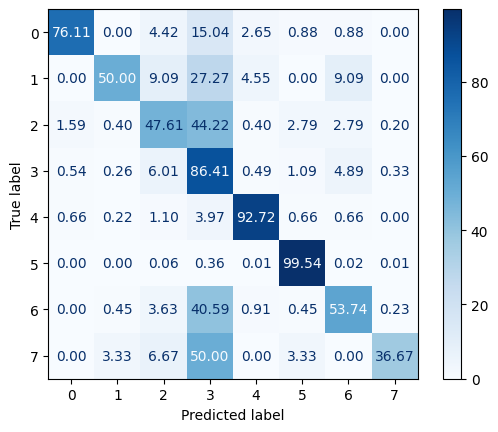

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 중요도 기반 선택
# 결정트리 모델로 특성 중요도 계산
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_multi, y_train_multi)
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_multi_reduced = selector.transform(X_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_reduced, y_train_multi)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


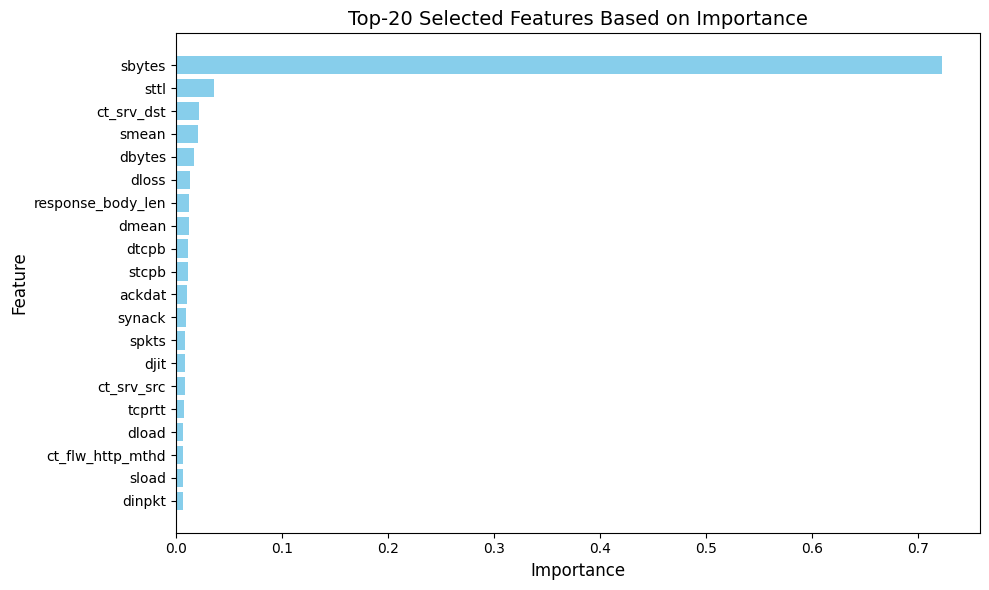

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 선택된 특징의 인덱스와 이름
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_binary.columns[selected_feature_indices]

# 선택된 특징의 중요도 추출
selected_feature_importances = importances[selected_feature_indices]

# 데이터프레임 생성 (이름과 중요도)
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': selected_feature_importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.title('Top-20 Selected Features Based on Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


###3. 클래스 불균형 해결

Performance Metrics (Decision Tree with SMOTE - Binary Classification):
Accuracy: 0.9808
Recall: 0.9871
Precision: 0.9873
F1-Score: 0.9872
Time to Train: 2.2140 seconds
Time to Predict: 0.0087 seconds

Classification Report (Decision Tree with SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



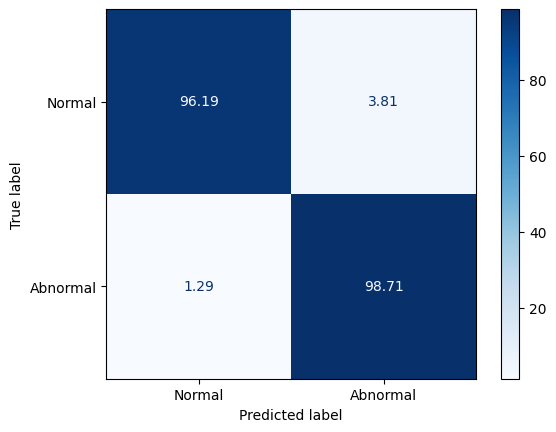

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary, y_train_binary)

# 2. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (Decision Tree with SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()



Classification Report (Decision Tree with SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       113
           1       0.30      0.36      0.33        22
           2       0.32      0.47      0.38       502
           3       0.88      0.80      0.84      4296
           4       0.89      0.93      0.91       453
           5       1.00      0.99      1.00     11591
           6       0.46      0.61      0.53       441
           7       0.28      0.37      0.31        30

    accuracy                           0.92     17448
   macro avg       0.60      0.65      0.62     17448
weighted avg       0.93      0.92      0.92     17448



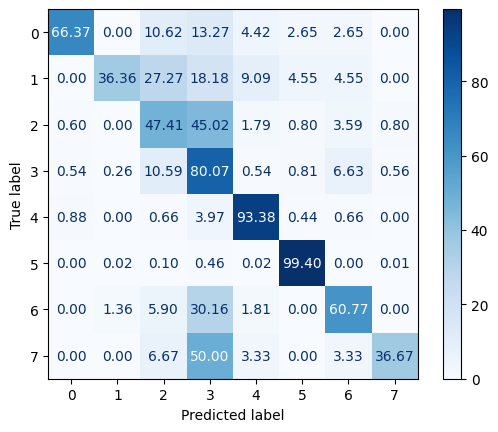

In [ ]:
# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi, y_train_multi)

# 2. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. Classification Report 출력
print("\nClassification Report (Decision Tree with SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###4. 특성 추출 + 클래스 불균형

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Importance + SMOTE - Binary Classification):
Accuracy: 0.9789
Recall: 0.9860
Precision: 0.9858
F1-Score: 0.9859
Time to Train: 1.4203 seconds
Time to Predict: 0.0032 seconds

Classification Report (Decision Tree with Feature Importance + SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



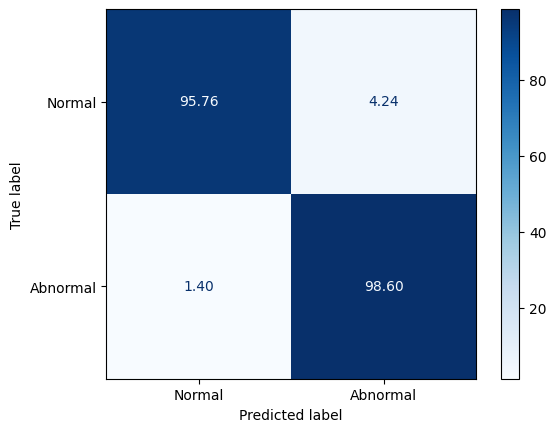

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 중요도 기반 선택
# 결정트리 모델로 특성 중요도 계산
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_binary, y_train_binary)  # 전체 데이터로 훈련
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_binary_reduced = selector.transform(X_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary_reduced, y_train_binary)

# 3. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 4. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("Performance Metrics (Decision Tree with Feature Importance + SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Importance + SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Importance + SMOTE - Multi-class):
Accuracy: 0.9137
Recall: 0.9137
Precision: 0.9269
F1-Score: 0.9189
Time to Train: 19.1353 seconds
Time to Predict: 0.0036 seconds

Classification Report (Decision Tree with Feature Importance + SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       113
           1       0.19      0.32      0.24        22
           2       0.31      0.48      0.38       502
           3       0.88      0.79      0.83      4296
           4       0.87      0.91      0.89       453
           5       1.00      0.99      0.99     11591
           6       0.46      0.61      0.52       441
           7       0.33      0.43      0.37        30

    accuracy                           0.91     17448
   macro avg       0.60      0.66      0.62     17448
weighted avg       0.93      0.91      0.92  

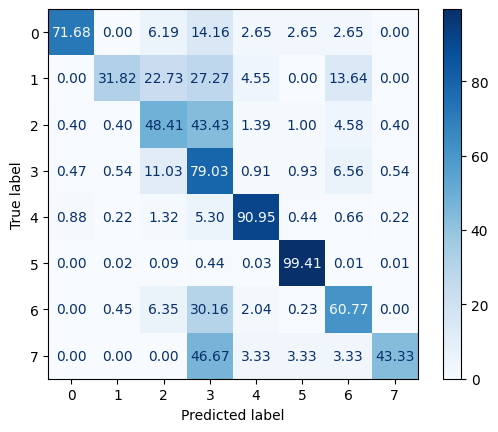

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 중요도 기반 선택
# 결정트리 모델로 특성 중요도 계산
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_multi, y_train_multi)  # 전체 데이터로 훈련
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_multi_reduced = selector.transform(X_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi_reduced, y_train_multi)

# 3. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 4. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("Performance Metrics (Decision Tree with Feature Importance + SMOTE - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Importance + SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###5. 하이퍼파라미터 튜닝

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.9873243323754649

Performance Metrics (Decision Tree - Binary Classification):
Accuracy: 0.9811
Recall: 0.9836
Precision: 0.9912
F1-Score: 0.9874
Time to Train: 39.6895 seconds
Time to Predict: 0.0164 seconds

Classification Report (Decision Tree - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      5823
    Abnormal       0.99      0.98      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



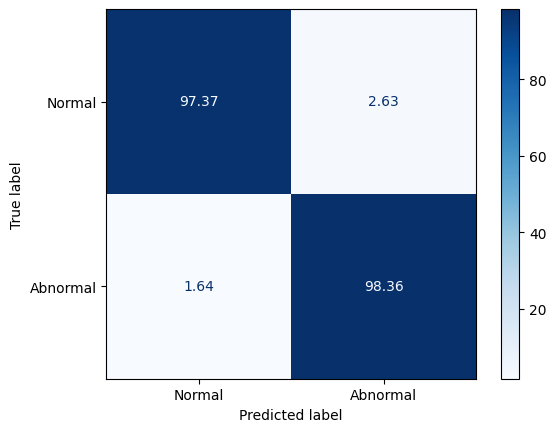

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1',
    cv=3,  # 교차 검증 폴드 수
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_binary = best_model.predict(X_test_binary)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("\nPerformance Metrics (Decision Tree - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 15, 'criterion': 'gini'}
Best score: 0.9363091412156125

Performance Metrics (Decision Tree - Multi-class):
Accuracy: 0.9407
Recall: 0.9407
Precision: 0.9377
F1-Score: 0.9384
Time to Train: 32.4010 seconds
Time to Predict: 0.0081 seconds

Classification Report (Decision Tree - Multi-class):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       113
           1       0.57      0.18      0.28        22
           2       0.58      0.40      0.47       502
           3       0.87      0.92      0.89      4296
           4       0.93      0.91      0.92       453
           5       1.00      0.99      0.99     11591
           6       0.56      0.54      0.55       441
           7       0.50      0.40      0.44        30

    accuracy                           0.94     17448
   

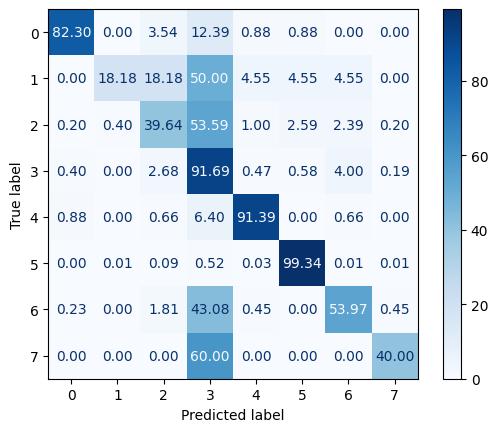

In [ ]:
# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_multi = best_model.predict(X_test_multi)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("\nPerformance Metrics (Decision Tree - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

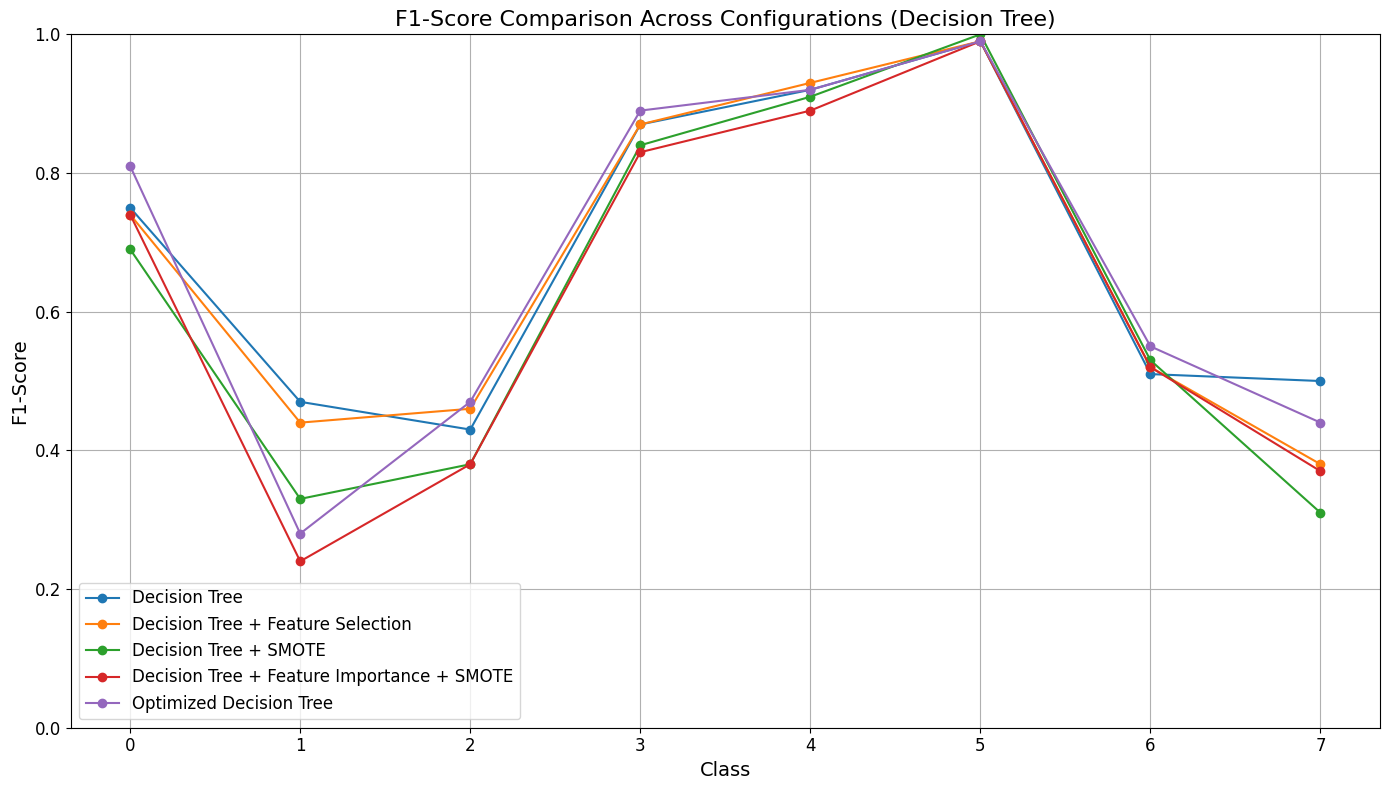

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# F1-scores extracted from the results
f1_scores = {
    "Decision Tree": [0.75, 0.47, 0.43, 0.87, 0.92, 0.99, 0.51, 0.50],
    "Decision Tree + Feature Selection": [0.74, 0.44, 0.46, 0.87, 0.93, 0.99, 0.52, 0.38],
    "Decision Tree + SMOTE": [0.69, 0.33, 0.38, 0.84, 0.91, 1.00, 0.53, 0.31],
    "Decision Tree + Feature Importance + SMOTE": [0.74, 0.24, 0.38, 0.83, 0.89, 0.99, 0.52, 0.37],
    "Optimized Decision Tree": [0.81, 0.28, 0.47, 0.89, 0.92, 0.99, 0.55, 0.44],
}

# Classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7']

# Plot
plt.figure(figsize=(14, 8))

for label, scores in f1_scores.items():
    plt.plot(classes, scores, marker='o', label=label)

plt.title("F1-Score Comparison Across Configurations (Decision Tree)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


##XGBoost

###1.기본

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:54:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics:
Accuracy: 0.9846
Recall: 0.9887
Precision: 0.9908
F1-Score: 0.9897
Time to Train: 14.5339 seconds
Time to Predict: 0.0592 seconds

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



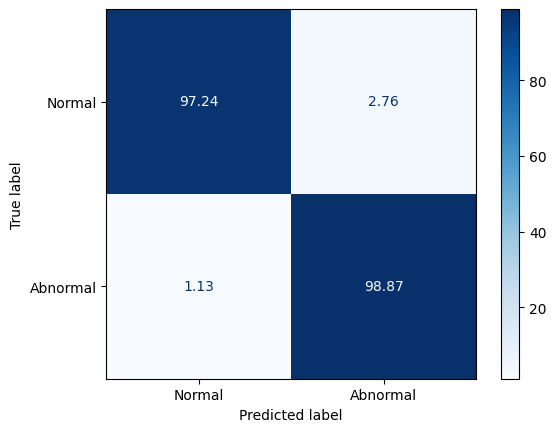

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 1. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 4. 성능 기록
performance_data.append({
    "Model": "XGBoost",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:54:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost - Multi-class):
Accuracy: 0.9469
Recall: 0.9469
Precision: 0.9447
F1-Score: 0.9434
Time to Train: 13.0848 seconds
Time to Predict: 0.2618 seconds

Classification Report (XGBoost - Multi-class):
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       113
           1       0.80      0.36      0.50        22
           2       0.72      0.34      0.46       502
           3       0.87      0.94      0.90      4296
           4       0.95      0.94      0.94       453
           5       1.00      1.00      1.00     11591
           6       0.56      0.56      0.56       441
           7       0.45      0.30      0.36        30

    accuracy                           0.95     17448
   macro avg       0.77      0.66      0.69     17448
weighted avg       0.94      0.95      0.94     17448



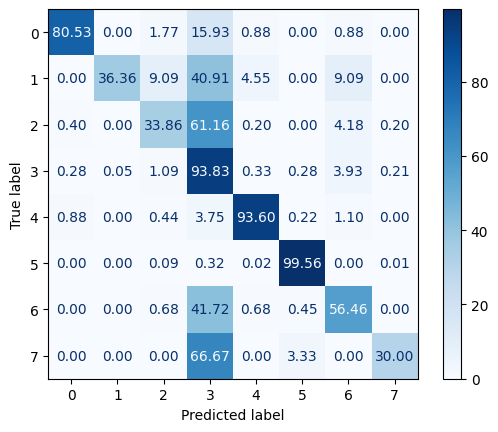

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 1. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 4. 성능 기록
performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics (XGBoost - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report (XGBoost - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###2. 특성 추출

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:54:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection - Binary Classification):
Accuracy: 0.9838
Recall: 0.9887
Precision: 0.9896
F1-Score: 0.9892
Time to Train: 1.1627 seconds
Time to Predict: 0.0469 seconds

Classification Report (XGBoost with Feature Selection - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



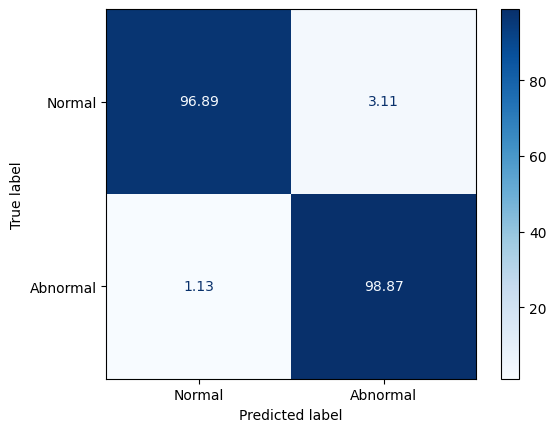

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_binary_reduced = selector.fit_transform(X_train_binary, y_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

# 2. 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary_reduced, y_train_binary)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:54:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection - Multi-class):
Accuracy: 0.9280
Recall: 0.9280
Precision: 0.9147
F1-Score: 0.9162
Time to Train: 10.1002 seconds
Time to Predict: 0.2302 seconds

Classification Report (XGBoost with Feature Selection - Multi-class):
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       113
           1       0.00      0.00      0.00        22
           2       0.48      0.17      0.25       502
           3       0.81      0.95      0.87      4296
           4       0.90      0.88      0.89       453
           5       1.00      0.99      0.99     11591
           6       0.37      0.13      0.20       441
           7       0.33      0.13      0.19        30

    accuracy                           0.93     17448
   macro avg       0.59      0.50      0.52     17448
weighted avg       0.91      0.93      0.92     17448



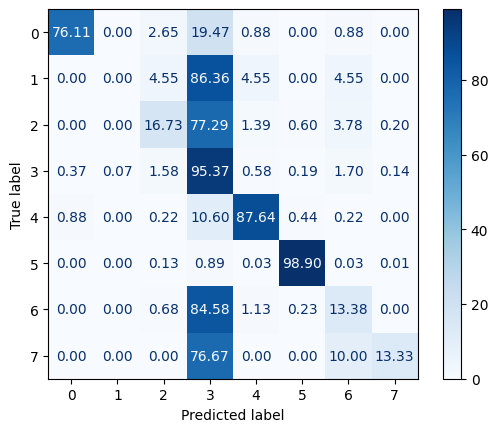

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_multi_reduced = selector.fit_transform(X_train_multi, y_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

# 2. 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi_reduced, y_train_multi)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})
# 7. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###3. 클래스 불균형 해결

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:55:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with SMOTE - Binary Classification):
Accuracy: 0.9850
Recall: 0.9874
Precision: 0.9925
F1-Score: 0.9899
Time to Train: 6.1477 seconds
Time to Predict: 0.0615 seconds

Classification Report (XGBoost with SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.99      0.98      0.98     23271



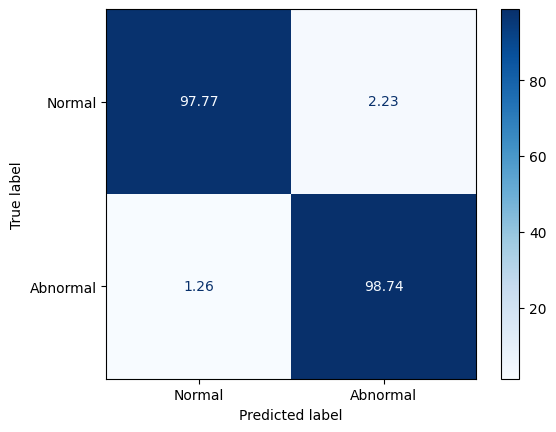

In [ ]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary, y_train_binary)

# 2. 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (XGBoost with SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (XGBoost with SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection - Multi-class):
Accuracy: 0.9309
Recall: 0.9309
Precision: 0.9407
F1-Score: 0.9343
Time to Train: 69.8964 seconds
Time to Predict: 0.2874 seconds

Classification Report (XGBoost with SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       113
           1       0.26      0.41      0.32        22
           2       0.44      0.50      0.47       502
           3       0.90      0.83      0.87      4296
           4       0.93      0.94      0.93       453
           5       1.00      0.99      1.00     11591
           6       0.48      0.79      0.60       441
           7       0.38      0.50      0.43        30

    accuracy                           0.93     17448
   macro avg       0.64      0.72      0.68     17448
weighted avg       0.94      0.93      0.93     17448



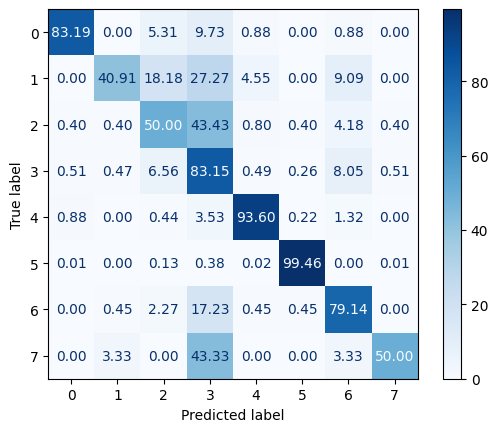

In [ ]:
# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi, y_train_multi)

# 2. 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. Classification Report 출력
print("\nClassification Report (XGBoost with SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###4. 특성 추출 + 클래스 불균형

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:56:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection + SMOTE - Binary Classification):
Accuracy: 0.9829
Recall: 0.9868
Precision: 0.9904
F1-Score: 0.9886
Time to Train: 2.4242 seconds
Time to Predict: 0.0728 seconds

Classification Report (XGBoost with Feature Selection + SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



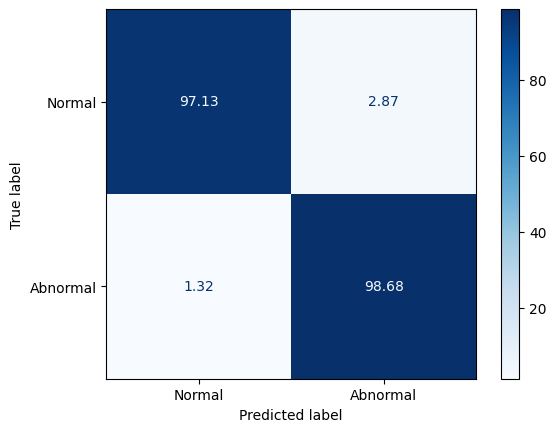

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_binary_reduced = selector.fit_transform(X_train_binary, y_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary_reduced, y_train_binary)

# 3. 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 4. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection + SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection + SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:56:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection + SMOTE - Multi-class):
Accuracy: 0.8957
Recall: 0.8957
Precision: 0.9215
F1-Score: 0.9057
Time to Train: 47.9325 seconds
Time to Predict: 0.2620 seconds

Classification Report (XGBoost with Feature Selection + SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       113
           1       0.07      0.18      0.10        22
           2       0.30      0.38      0.33       502
           3       0.87      0.75      0.80      4296
           4       0.87      0.88      0.88       453
           5       1.00      0.99      0.99     11591
           6       0.30      0.62      0.41       441
           7       0.05      0.17      0.08        30

    accuracy                           0.90     17448
   macro avg       0.51      0.60      0.54     17448
weighted avg       0.92      0.90      0.91     17448



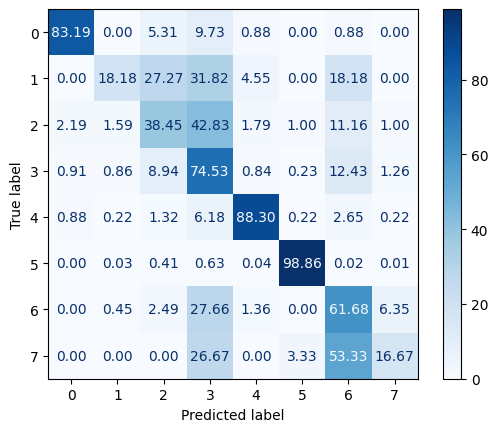

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_multi_reduced = selector.fit_transform(X_train_multi, y_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi_reduced, y_train_multi)

# 3. 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 4. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection + SMOTE - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection + SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###5. 하이퍼파라미터 튜닝

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:57:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters: {'subsample': 0.8, 'reg_lambda': 50, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best score: 0.9894253818499252

Performance Metrics (XGBoost - Binary Classification):
Accuracy: 0.9852
Recall: 0.9899
Precision: 0.9904
F1-Score: 0.9901
Time to Train: 156.5891 seconds
Time to Predict: 0.1696 seconds

Classification Report (XGBoost - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.99     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.99      0.99      0.99     23271



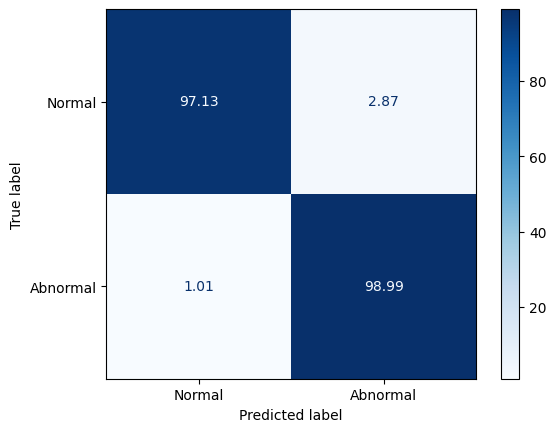

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt

# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 50, 100]
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1',  # 이진분류에서 F1 점수를 기준으로 최적화
    cv=3,  # 교차 검증 folds
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_binary = best_model.predict(X_test_binary)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("\nPerformance Metrics (XGBoost - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (XGBoost - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:00:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:00:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:01:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:01:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:01:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters: {'subsample': 1.0, 'reg_lambda': 100, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best score: 0.9395786323365479

Performance Metrics (XGBoost - Multi-class):
Accuracy: 0.9454
Recall: 0.9454
Precision: 0.9431
F1-Score: 0.9409
Time to Train: 955.3872 seconds
Time to Predict: 0.3130 seconds

Classification Report (XGBoost - Multi-class):
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       113
           1       1.00      0.05      0.09        22
           2       0.69      0.28      0.40       502
           3       0.87      0.94      0.90      4296
           4       0.94      0.93      0.94       453
           5       1.00      0.99      1.00     11591
           6       0.58      0.60      0.59       441
           7       0.50      0.53      0.52        30

    accuracy                           0.95     17448
   macro avg       0.80      0.64      0.66    

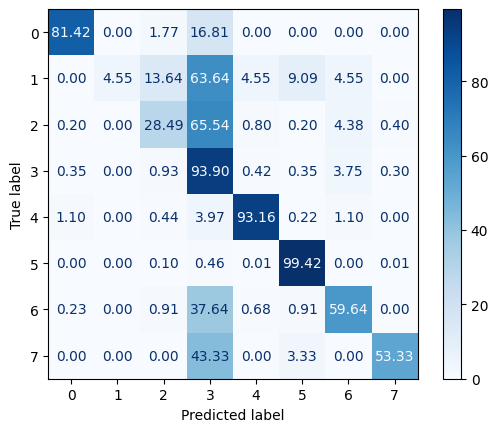

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt
# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 50, 100]
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1_weighted',  # 다중분류에서 weighted F1 점수를 기준으로 최적화
    cv=3,
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_multi = best_model.predict(X_test_multi)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("\nPerformance Metrics (XGBoost - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 8. Classification Report 출력
print("\nClassification Report (XGBoost - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


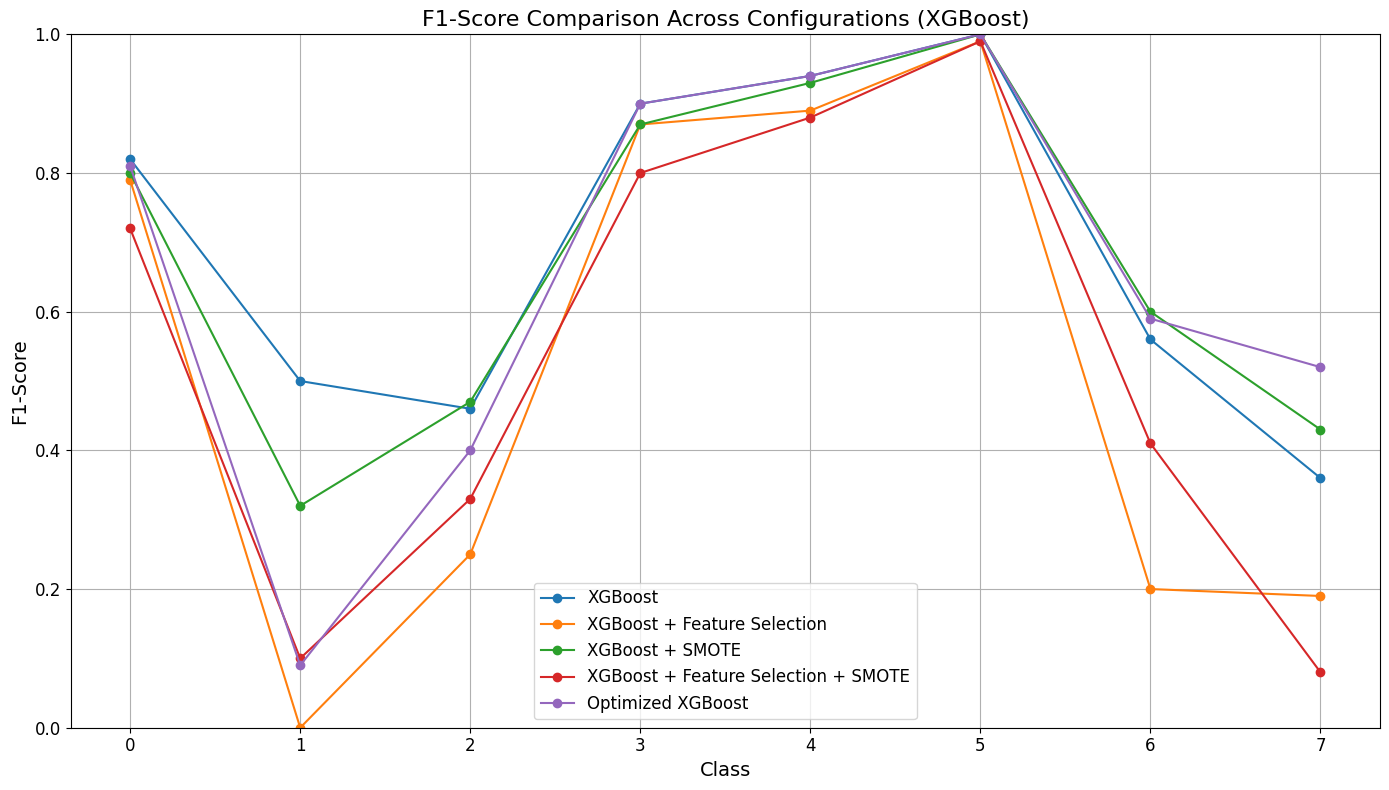

In [ ]:
import matplotlib.pyplot as plt

# F1-scores extracted from the results
f1_scores_xgboost = {
    "XGBoost": [0.82, 0.50, 0.46, 0.90, 0.94, 1.00, 0.56, 0.36],
    "XGBoost + Feature Selection": [0.79, 0.00, 0.25, 0.87, 0.89, 0.99, 0.20, 0.19],
    "XGBoost + SMOTE": [0.80, 0.32, 0.47, 0.87, 0.93, 1.00, 0.60, 0.43],
    "XGBoost + Feature Selection + SMOTE": [0.72, 0.10, 0.33, 0.80, 0.88, 0.99, 0.41, 0.08],
    "Optimized XGBoost": [0.81, 0.09, 0.40, 0.90, 0.94, 1.00, 0.59, 0.52],
}

# Classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7']

# Plot
plt.figure(figsize=(14, 8))

for label, scores in f1_scores_xgboost.items():
    plt.plot(classes, scores, marker='o', label=label)

plt.title("F1-Score Comparison Across Configurations (XGBoost)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


##CNN

###0. 이진분류

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_binary.values
y_train = y_train_binary.values
X_test = X_test_binary.values
y_test = y_test_binary.values

# SMOTE 적용 (이진분류를 위한 데이터 증강)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 데이터의 총 특성 수
num_features = X_resampled.shape[1]

# height와 width를 동적으로 설정
for h in range(1, num_features + 1):  # height를 가능한 값으로 탐색
    if num_features % h == 0:         # 나누어 떨어지는 경우 선택
        height = h
        width = num_features // h
        break

print(f"Reshaping data into shape: (1, {height}, {width})")

# CNN 입력용으로 데이터 변환
X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. CNN 모델 정의
class CNNBinaryClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNNBinaryClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.flatten_size = None
        self.fc1 = None
        self.fc2 = None

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        if self.fc1 is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, 2).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
dropout_prob = 0.4
model = CNNBinaryClassifier(dropout_prob=dropout_prob)

class_counts = np.bincount(y_resampled)
class_weights = len(y_resampled) / (2 * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 조기 종료 설정
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# 4. 학습 루프
epochs = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
end_train = time.time()

# 5. 성능 평가
model.eval()
y_true = []
y_pred = []
start_predict = time.time()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 6. 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "F1-Score": f1_score(y_true, y_pred),
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. 성능 데이터 출력
print("Performance Data:")
print(performance_data)

Original dataset shape: {0: 23290, 1: 69791}
Resampled dataset shape: {0: 69791, 1: 69791}
Reshaping data into shape: (1, 1, 39)


RuntimeError: Given input size: (32x1x39). Calculated output size: (32x0x19). Output size is too small

###1. 기본

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time

# 1. 데이터 준비
# 2D 데이터 형태로 변환 (예: [batch_size, 1, height, width])
height = 8
width = X_train_multi.shape[1] // height

X_train_cnn = X_train_multi.values.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test_multi.values.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_multi.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_multi.values, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = None

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        if self.fc1 is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(y_train_multi.unique())
model = CNNMultiClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4. 학습 루프
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
end_train = time.time()

# 5. 성능 평가
model.eval()
y_true = []
y_pred = []
start_predict = time.time()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_train - start_train:.2f} seconds")

# 6. 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": None,
    "Precision": None,
    "F1-Score": None,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. 학습 결과 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###2. 클래스 불균형 - 클래스 샘플 개수 기반으로 가중치 계산

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time

# 1. 데이터 준비
height = 8  # 예시로 설정 (가로*세로=특성 수)
width = X_train_multi.shape[1] // height

X_train_cnn = X_train_multi.values.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test_multi.values.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_multi.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_multi.values, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. 클래스 가중치 계산
class_counts = y_train_multi.value_counts().sort_index()
total_samples = len(y_train_multi)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

# 3. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = None

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        if self.fc1 is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 4. 모델 생성 및 학습 설정
num_classes = len(y_train_multi.unique())
model = CNNMultiClassifier(num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 5. 학습 루프
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
end_train = time.time()

# 6. 성능 평가
start_predict = time.time()
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_train - start_train:.2f} seconds")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###2. 클래스 불균형 - SMOTE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_multi.values
y_train = y_train_multi.values
X_test = X_test_multi.values
y_test = y_test_multi.values

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 2D 데이터 변환 (CNN 입력용)
height = 8
width = X_resampled.shape[1] // height

X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        self.flatten_size = None  # Flatten 크기 계산
        self.fc1 = None  # Fully Connected Layer 1 (크기는 forward에서 설정)
        self.fc2 = None  # Fully Connected Layer 2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        if self.fc1 is None:  # 첫 forward 호출 시 동적으로 Fully Connected Layer 생성
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(np.unique(y_train))
model = CNNMultiClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4. 학습 루프
start_train = time.time()  # 학습 시작 시간
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
end_train = time.time()  # 학습 종료 시간

# 5. 성능 평가
start_predict = time.time()  # 예측 시작 시간
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()  # 예측 종료 시간

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. 결과 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###3. 하이퍼파라미터 튜닝

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_multi.values
y_train = y_train_multi.values
X_test = X_test_multi.values
y_test = y_test_multi.values

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 2D 데이터 변환 (CNN 입력용)
height = 8
width = X_resampled.shape[1] // height

X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        self.flatten_size = None  # Flatten 크기 계산
        self.fc1 = None  # Fully Connected Layer 1
        self.fc2 = None  # Fully Connected Layer 2

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pooling
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pooling
        if self.fc1 is None:  # 첫 forward 호출 시 동적으로 Fully Connected Layer 생성
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(np.unique(y_train))
model = CNNMultiClassifier(num_classes)

# 클래스 가중치 계산
class_counts = np.bincount(y_resampled)
class_weights = len(y_resampled) / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 적용
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 학습률 스케줄러 추가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 조기 종료 설정
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# 4. 학습 루프
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
end_train = time.time()

# 5. 성능 평가
start_predict = time.time()
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###4. 불균형 해결 + 하이퍼파라미터 튜닝

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_multi.values
y_train = y_train_multi.values
X_test = X_test_multi.values
y_test = y_test_multi.values

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 2D 데이터 변환 (CNN 입력용)
height = 8
width = X_resampled.shape[1] // height

X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
batch_size = 128  # 배치 크기 조정
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        self.dropout = nn.Dropout(dropout_prob)  # 드롭아웃 추가
        self.flatten_size = None  # Flatten 크기 계산
        self.fc1 = None  # Fully Connected Layer 1
        self.fc2 = None  # Fully Connected Layer 2

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pooling
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pooling
        if self.fc1 is None:  # 첫 forward 호출 시 동적으로 Fully Connected Layer 생성
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(np.unique(y_train))
dropout_prob = 0.4  # 드롭아웃 확률 조정
model = CNNMultiClassifier(num_classes, dropout_prob=dropout_prob)

# 클래스 가중치 계산
class_counts = np.bincount(y_resampled)
class_weights = len(y_resampled) / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 적용
learning_rate = 0.0005  # 학습률 조정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # 학습률 스케줄러 추가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 조기 종료 설정
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# 4. 학습 루프
epochs = 25  # 에포크 수 증가
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# 5. 성능 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 6. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 성능 비교

In [ ]:
# performance_data가 리스트일 경우, DataFrame으로 변환
performance_df = pd.DataFrame(performance_data)

# 성능 데이터프레임 스타일링
styled_table = (
    performance_df.style
    .background_gradient(cmap="coolwarm_r", subset=["Accuracy"])  # 정확도: 낮을수록 warm (빨간색), 높을수록 cool (파란색)
    .background_gradient(cmap="coolwarm", subset=["Time to Train", "Total Time"])  # 시간: 낮을수록 cool (파란색), 높을수록 warm (빨간색)
    .format({"Accuracy": "{:.4%}", "Time to Train": "{:.2f}", "Total Time": "{:.2f}"})
    .set_caption("Model Performance Summary")
)

# 테이블 출력
styled_table

,Model,Type,Accuracy,Recall,Precision,F1-Score,Time to Train,Time to Predict,Total Time
0,Decision Tree,Multi-class,92.8187%,0.928187,0.931023,0.929467,1.36,0.006944,1.37
1,Decision Tree,Binary,97.9245%,0.987105,0.985241,0.986172,0.99,0.003475,0.99
2,Decision Tree,Multi-class,93.1568%,0.931568,0.933052,0.932250,0.94,0.003835,0.95
3,Decision Tree,Binary,98.0792%,0.987105,0.987274,0.987189,2.21,0.008734,2.22
4,Decision Tree,Multi-class,91.6094%,0.916094,0.928157,0.920914,31.72,0.007798,31.72
5,Decision Tree,Binary,97.8858%,0.985958,0.985845,0.985902,1.42,0.003217,1.42
6,Decision Tree,Multi-class,91.3686%,0.913686,0.926920,0.918875,19.14,0.003647,19.14
7,Decision Tree,Binary,98.1135%,0.983608,0.991164,0.987372,39.69,0.016435,39.71
8,Decision Tree,Multi-class,94.0681%,0.940681,0.937716,0.938410,32.40,0.008139,32.41
9,XGBoost,Binary,98.4616%,0.988709,0.990754,0.989730,14.53,0.059220,14.59


In [ ]:
# performance_data가 리스트일 경우, DataFrame으로 변환
performance_df = pd.DataFrame(performance_data)

# 성능 데이터프레임 스타일링
styled_table = (
    performance_df.style
    .background_gradient(cmap="coolwarm_r", subset=["Accuracy"])  # 정확도: 낮을수록 warm (빨간색), 높을수록 cool (파란색)
    .background_gradient(cmap="coolwarm", subset=["Time to Train", "Total Time"])  # 시간: 낮을수록 cool (파란색), 높을수록 warm (빨간색)
    .format({"Accuracy": "{:.4%}", "Time to Train": "{:.2f}", "Total Time": "{:.2f}"})
    .set_caption("Model Performance Summary")
)

# 테이블 출력
styled_table

,Model,Type,Accuracy,Recall,Precision,F1-Score,Time to Train,Time to Predict,Total Time
0,Decision Tree,Binary,97.9631%,0.987105,0.985749,0.986426,5.41,0.041275,5.45
